- $K$-means Clustering and Principal Component Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.io as sio
import math
from sklearn.cluster import KMeans

# Two-dimensional $K$-means

In [18]:
def load_mat(Path):
    Path = Path
    mat = sio.loadmat(Path)
    
    return mat

def generate_df(data, X_key):
    return pd.DataFrame(data.get(X_key), columns=['X1', 'X2'])

In [19]:
data1 = load_mat('./data/ex7data1.mat')

data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

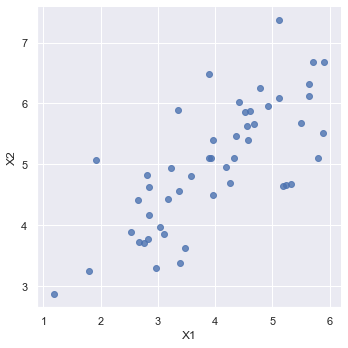

In [20]:
df1 = generate_df(data1, 'X')

sns.set()

sns.lmplot('X1', 'X2', data=df1, fit_reg=False)
plt.show()

In [6]:
data2 = load_mat('./data/ex7data2.mat')
df2 = generate_df(data2, 'X')
df2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


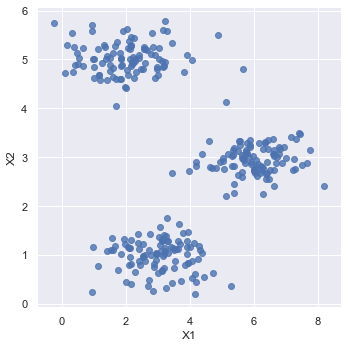

In [7]:
data2.keys()

sns.lmplot('X1', 'X2', data=df2, fit_reg=False)
plt.show()

## Random initialization

### Finding closest centroids
In the "cluster assignment" phase of the $K$-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set $$c^{(i)}:=j \ \text{that minimizes} \ ||x^{(i)}-\mu_j||^2,$$ where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j$'th centroid.

In [2]:
def addColumns(X, idx_n):
    X_added = X.copy()
    X_added['idx'] = idx_n
    
    return X_added

def kMeansInitCentroids(X, K):
    """choose k sample from data set as init centroids
    Args:
        X: DataFrame
        K: int
    Returns:
        K samples: ndarray
    """
    
    return X.sample(K).values

def findClosetCentroid(X, centroids):
    """
    FINDCLOSESTCENTROIDS computes the centroid memberships for every example
       idx = FINDCLOSESTCENTROIDS (X, centroids) returns the closest centroids
       in idx for a dataset X where each row is a single example. idx = m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])
    """
    # set K
#     K = centroids.shape[0]
#     print(K)
    # set idx
#     idx = []
    # cost 
#     progress_cost = []
    
#     for i in range(int(K)):
#         name = str(i)
#         X[name] = X[['X1','X2']].apply(lambda x:((x-centroids[i])**2).sum(),axis =1)
#     for i in range(int(X.shape[0])):
#         dist = []
#         for j in range(int(K)):
#             dist.append(math.sqrt((X['X1'][i] - centroids[j][0])**2 + (X['X2'][i] - centroids[j][1])**2))
#         idx.append(np.argmin(dist))
    dist = np.apply_along_axis(func1d=np.linalg.norm, axis=1, arr=centroids-X)
    idx = np.argmin(dist)
    
    return idx

def AssignCluster(X, centroids):
    """assign cluster for each node in data
    return idx_n ndarray
    """
    return np.apply_along_axis(lambda x: findClosetCentroid(x, centroids),
                               axis=1,
                               arr=X.values)

def computeCentroids(X, idx_n):
   
    X_added = addColumns(X, idx_n)
#     print(X_added)# agg('mean')
    centroids = X_added.groupby('idx', as_index=False).mean().sort_values(by='idx').\
                drop('idx', axis=1).values
    
    return centroids

def cost(data, centroids, idx_n):
    m = data.shape[0]

    idx_centroids = centroids[idx_n]
#     print(idx_centroids)

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.values - idx_centroids)
    return distances.sum() / m

### Computing centroid means
Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set $$\mu_k:=\frac{1}{|C_k|}\sum\limits_{i\in C_k}x^{(i)}$$ where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely,if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k$ = 2, then you should update $\mu_2 = \frac{1}{2} (x^{(3)} + x^{(5)})$.

## $K$-means on example dataset

In [3]:
def runkMeans(X, K, _iter=100, tol=0.0001):
    """
    RUNKMEANS runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
       [centroids, idx] = RUNKMEANS(X, initial_centroids, max_iters, ...
       plot_progress) runs the K-Means algorithm on data matrix X, where each 
       row of X is a single example. It uses initial_centroids used as the
       initial centroids. max_iters specifies the total number of interactions 
       of K-Means to execute. plot_progress is a true/false flag that 
       indicates if the function should also plot its progress as the 
       learning happens. This is set to false by default. runkMeans returns 
       centroids, a Kxn matrix of the computed centroids and idx, a m x 1 
       vector of centroid assignments (i.e. each entry in range [1..K])
    """
    
    centroids = kMeansInitCentroids(X, K)
    progress_cost = []
    
    for i in range(int(_iter)):
        print('running iter {}'.format(i))
        idx_n = AssignCluster(X, centroids)
        centroids = computeCentroids(X, idx_n)
#         print(centroids)
        cost1 = cost(X, centroids, idx_n)
#         print(cost1)
        progress_cost.append(cost1)
        
#         print(progress_cost)


        if len(progress_cost) > 1:  # early break
            delta = (np.abs(progress_cost[-1] - progress_cost[-2])) / progress_cost[-1]
#             print(progress_cost[-2])
#             print(progress_cost[-1])
#             print(delta)
            if delta < tol:
                break
            
    
    return idx_n, centroids, progress_cost[-1]            

def k_means(X, K, _iter=100, n_init=10):
    """do multiple random init and pick the best one to return
    Args:
        X (pd.DataFrame)
    Returns:
        (idx_n, centroids, least_cost)
    """

    tries = np.array([runkMeans(X, K, _iter) for _ in range(n_init)])

    least_cost_idx = np.argmin(tries[:, -1])

    return tries[least_cost_idx]

In [12]:
best_idx, best_cen, least_cost = k_means(df2, 3)

running iter 0
running iter 1
running iter 2
running iter 3
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 0
running iter 1
running iter 2
running iter 0
running iter 1
running iter 2
running iter 3
running iter 0
running iter 1
running iter 2
running iter 0
running iter 1
running iter 2
running iter 3
running iter 0
running iter 1
running iter 2
running iter 3
running iter 0
running iter 1
running iter 2
running iter 3
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4


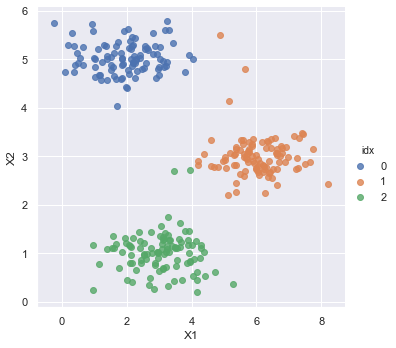

In [15]:
df_added = addColumns(df2, best_idx)
sns.lmplot('X1', 'X2', hue='idx', data=df_added, fit_reg=False)
plt.show()

In [16]:
init_cen = kMeansInitCentroids(df2, 3)
init_cen

array([[5.37052667, 2.44954813],
       [1.38133497, 5.00194962],
       [2.1270185 , 0.95672042]])

In [26]:
x = np.array([1,1])

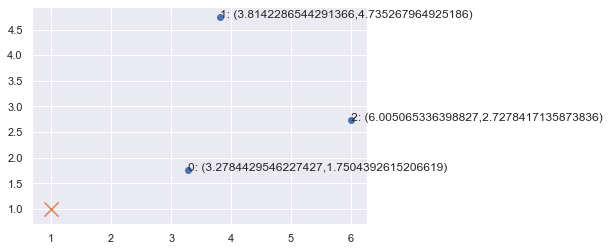

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x=init_cen[:, 0], y=init_cen[:, 1])

for i, node in enumerate(init_cen):
    ax.annotate('{}: ({},{})'.format(i, node[0], node[1]), node)
    
ax.scatter(x[0], x[1], marker='x', s=200)
plt.show()

In [28]:
findClosetCentroid(x, init_cen)

0

In [29]:
idx_n = AssignCluster(df2, init_cen)
df2_added = addColumns(df2, idx_n)
df2_added.head()

,X1,X2,idx
0,1.842080,4.607572,1
1,5.658583,4.799964,1
2,6.352579,3.290854,2
3,2.904017,4.612204,1
4,3.231979,4.939894,1


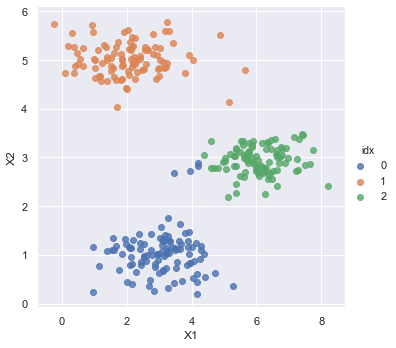

In [30]:
sns.lmplot('X1', 'X2', hue='idx', data=df2_added, fit_reg=False)
plt.show()

In [31]:
computeCentroids(df2, idx_n)

array([[3.06584667, 1.05078048],
       [2.05132113, 5.01925539],
       [6.0976967 , 2.94636078]])

In [19]:
final_idx, final_cen, _ = runkMeans(df2, 3)
df2_added = addColumns(df2, final_idx)

running iter 0
running iter 1


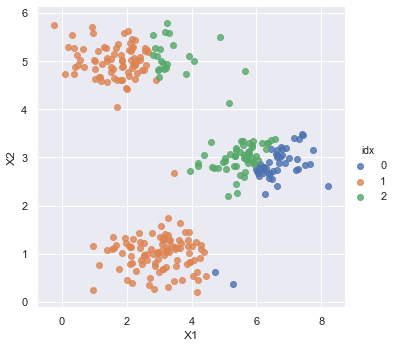

In [20]:
sns.lmplot('X1', 'X2', hue='idx', data=df2_added, fit_reg=False)
plt.show()

In [22]:
least_cost

0.7945269665438931

## Try sklearn $K$-means

In [24]:
_Kmeans = KMeans(n_clusters=3)

In [25]:
_Kmeans.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
sk_idx = _Kmeans.predict(df2)

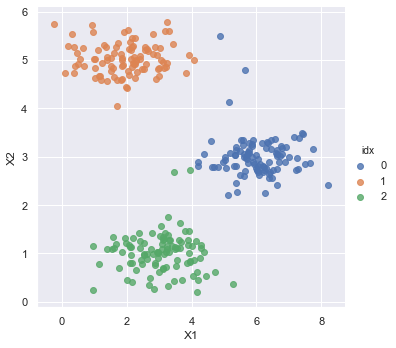

In [27]:
df_added = addColumns(df2, sk_idx)
sns.lmplot('X1', 'X2', hue='idx', data=df_added, fit_reg=False)
plt.show()

# $K$-means for image compression

In [4]:
from skimage import io

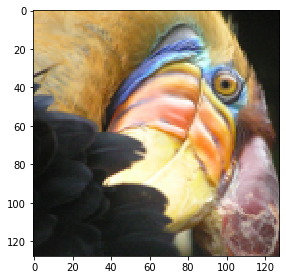

In [5]:
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)

- Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128x128 pixel locations, resulting in total size of 128$\times$128$\times$24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16$\times$24 + 128$\times$128$\times$4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

In [6]:
pic.shape

(128, 128, 3)

In [7]:
picArray = pic.reshape(128*128, 3)

In [8]:
best_idx, centroids, cost = k_means(pd.DataFrame(picArray), 16, 10, 6)

running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9
running iter 0
running iter 1
running iter 2
running iter 3
running iter 4
running iter 5
running iter 6
running iter 7
running iter 8
running iter 9


In [9]:
compressed_pic = centroids[best_idx].reshape((128,128,3))

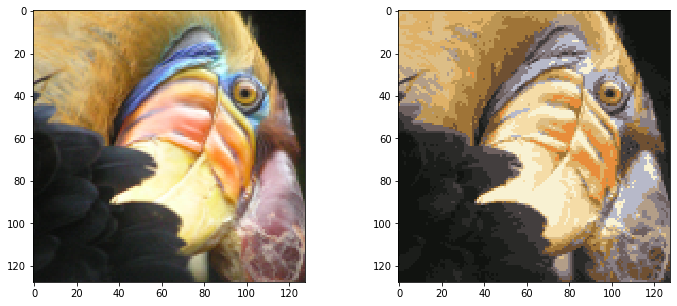

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
# ax.subplot(1, 2, 1)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## sklearn Kmeans compression

In [12]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)
model.fit(picArray)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
centroids1 = model.cluster_centers_
print(centroids.shape)

idx = model.predict(picArray)
print(idx.shape)

(16, 3)
(16384,)


In [14]:
compressed_pic1 = centroids1[idx].reshape((128,128,3))

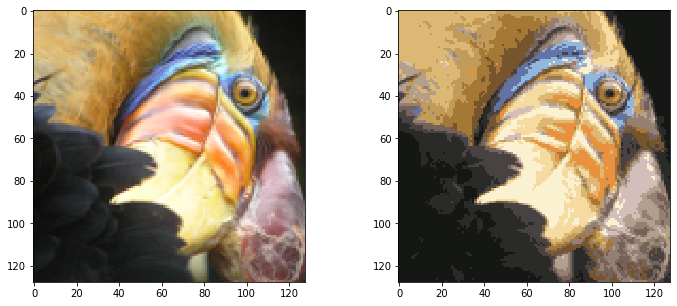

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
# ax.subplot(1, 2, 1)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic1)
plt.show()

# Principle component analysis

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: First, you compute the covariance matrix of the data.Then, you use Octave/MATLAB's SVD function to compute the eigenvectors $U_1; U_2; ... ;U_n$. These will correspond to the principal components of
variation in the data.

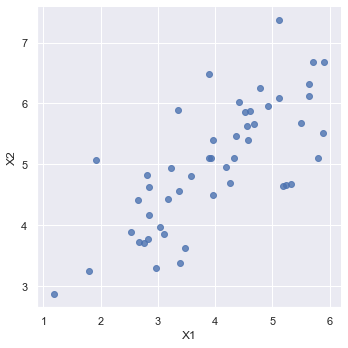

In [21]:
sns.lmplot('X1', 'X2', data=df1, fit_reg=False)
plt.show()

## Normalize data

Before using PCA, it is important to first normalize the data by subtract-
ing the mean value of each feature from the dataset, and scaling each dimen-
sion so that they are in the same range. 

In [54]:
def featureNormalize(X):
    """
    FEATURENORMALIZE Normalizes the features in X 
      FEATURENORMALIZE(X) returns a normalized version of X where
      the mean value of each feature is 0 and the standard deviation
      is 1. This is often a good preprocessing step to do when
      working with learning algorithms.
    """
    X_copy = X.copy()
    _, n = X_copy.shape
    
    for col in range(n):
        X_copy[:, col] = (X_copy[:, col] - X_copy[:, col].mean()) / \
                          X_copy[:, col].std()
        
    return X_copy

After normalizing the data, you can run PCA to compute the principal components. Your task is to complete the code in pca.m to compute the principal components of the dataset. First, you should compute the covariance matrix of the data, which is given by: $$\sum=\frac{1}{m}X^TX$$ where $X$ is the data matrix with examples in rows, and $m$ is the number of examples. Note that $\sum$ is a $n\times n$ matrix and not the summation operator.

In [28]:
rr.shape[0]

3

In [29]:
rr @ rr.T

array([[ 5,  8, 11],
       [ 8, 13, 18],
       [11, 18, 25]])

In [32]:
def covarianceMatrix(X):
    """
    compute covariance matrix
    """
    m = X.shape[0]
    
    return (X.T @ X) / m

After computing the covariance matrix, you can run SVD on it to compute the principal components. In Octave/MATLAB, you can run SVD with the following command: [$U, S, V$] = svd(Sigma), where $U$ will contain the principal components and $S$ will contain a diagonal matrix.

In [39]:
def PCA(X):
    """
    Instructions: You should first compute the covariance matrix. Then, you
               should use the "svd" function to compute the eigenvectors
               and eigenvalues of the covariance matrix. 
    Args:
        X ndarray(m, n)
    Returns:
        Returns the eigenvectors U, the eigenvalues (on diagonal) in S
        U will contain the principal components and S will contain a diagonal matrix.
    """
    # initialization
    X_norm = featureNormalize(X)
    
    # calculate Covariance matrix
    CovMatrix = covarianceMatrix(X_norm)
    
    # Sigular value decomposition
    
    U, S, V = np.linalg.svd(CovMatrix)
    
    return U, S, V

In [38]:
df1.values.shape

(50, 2)

In [40]:
PCA(df1.values)

(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]),
 array([1.73553038, 0.26446962]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

## Dimensionality reduction with PCA

### Projecting the data onto the principal components
You should project each example in $X$ onto the top $K$ components in $U$. Note that the top $K$ components in $U$ are given by the first $K$ columns of $U$, $U_{reduce} = U(:, 1:K)$, $z^{(i)}=U_{reduce}^Tx^{(i)}$

In [41]:
def projectData(X, U, K):
    """
    PROJECTDATA Computes the reduced data representation when projecting only 
    on to the top k eigenvectors
        Z = projectData(X, U, K) computes the projection of 
        the normalized inputs X into the reduced dimensional space spanned by
        the first K columns of U. It returns the projected examples in Z.
    """
    
    m, n = X.shape
    
    if K > n:
        raise ValueError('K should be lower dimension of n !')
        
    return X @ U[:, :K]        

### Reconstructing an approximation of the data

For the i-th example $Z$(i,:), the (approximate) recovered data for dimension j is given as follows:$$v = Z(i, :)^T;$$ $$X_{rec} = U_{reduce}Z=v^TU(j,1:k)^T$$

In [99]:
def recoverData(Z, U):
    """
    RECOVERDATA Recovers an approximation of the original data when using the 
    projected data
        X_rec = RECOVERDATA(Z, U, K) recovers an approximation the 
        original data that has been reduced to K dimensions. It returns the
        approximate reconstruction in X_rec.
    """
#     m, n = Z.shape
    X_rec = np.zeros((Z.shape[0], U.shape[0]))
    X_rec = Z @ U[:, :Z.shape[1]].T
    
#     if n >= U.shape[0]:
#         raise ValueError('Z dimension is >= U, you should recover the data by projecting \
#                          them back onto the original high dimensional space')
    
    return X_rec#Z @ U[:, :n].T

### Visualizing the projections

In [45]:
def plotDataPoints(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

#### Normlize data

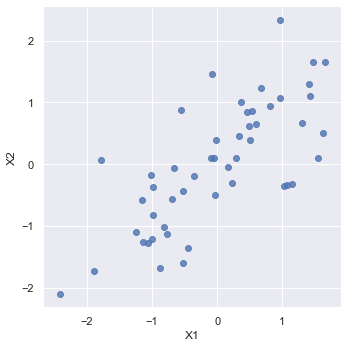

In [55]:
X_norm = featureNormalize(df1.values)

sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

#### Compute $\sum$

In [68]:
Cov =covarianceMatrix(X_norm)  # capital greek Sigma
Cov  # (n, n)

array([[1.        , 0.73553038],
       [0.73553038, 1.        ]])

#### PCA

In [59]:
U, S, V = PCA(df1.values)

#### Projection

In [60]:
# show top 10 projected data
Z = projectData(X_norm, U, 1)
Z[:10]

array([[ 1.49631261],
       [-0.92218067],
       [ 1.22439232],
       [ 1.64386173],
       [ 1.2732206 ],
       [-0.97681976],
       [ 1.26881187],
       [-2.34148278],
       [-0.02999141],
       [-0.78171789]])

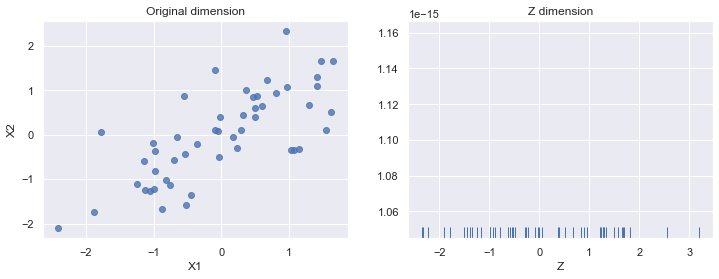

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax1)
ax1.set_title('Original dimension')

sns.rugplot(Z, ax=ax2)
ax2.set_xlabel('Z')
ax2.set_title('Z dimension')
plt.show()

#### Recover data to original dimension

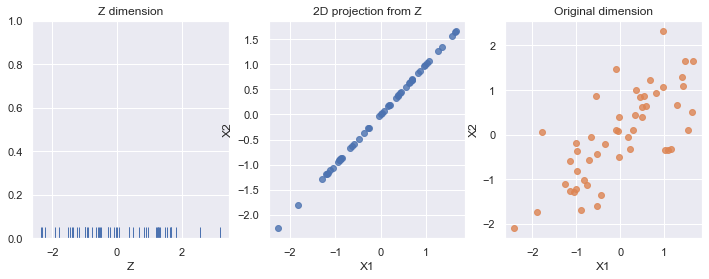

In [100]:
X_recover = recoverData(Z, U)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

sns.rugplot(Z, ax=ax1)
ax1.set_title('Z dimension')
ax1.set_xlabel('Z')

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_recover, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax2)
ax2.set_title("2D projection from Z")

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax3)
ax3.set_title('Original dimension')
plt.show()

# Run PCA on face images

In [69]:
faceData = load_mat('./data/ex7faces.mat')
faceData.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [73]:
faceData['X'][0].shape

(1024,)

In [108]:
# turn angel
X = np.array([x.reshape((32, 32)).T.reshape(1024) for x in faceData.get('X')])
X.shape

(5000, 1024)

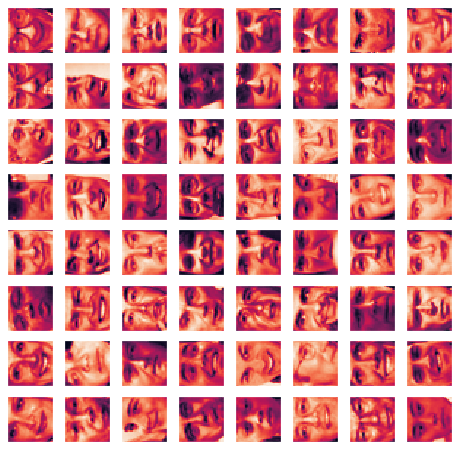

In [106]:
plotDataPoints(faceData['X'], 64)

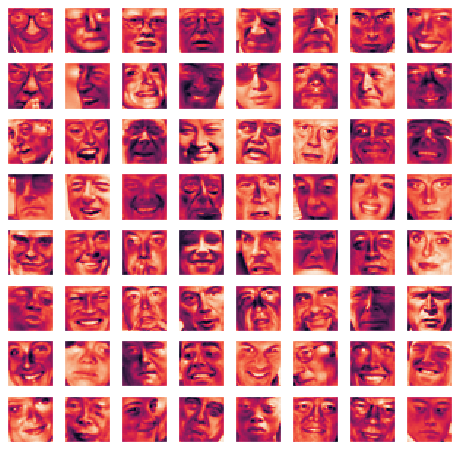

In [107]:
plotDataPoints(X, 64)

## PCA on Faces

In [87]:
U_faces, S_faces, V_faces = PCA(X)

In [89]:
U_faces.shape

(1024, 1024)

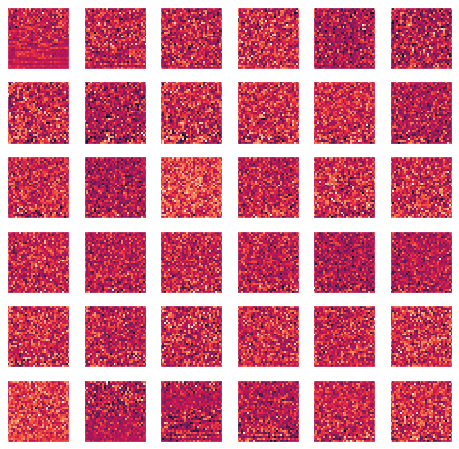

In [90]:
plotDataPoints(U_faces, 36)

## Rudece dimension to $K=100$

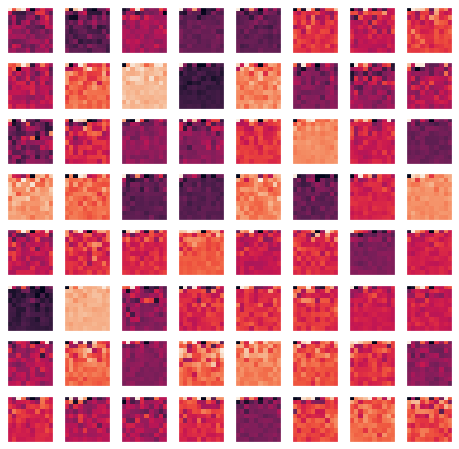

In [103]:
# no face in projected dimension too
Z_faces = projectData(X, U_faces, 100)
plotDataPoints(Z_faces, n=64)
plt.show()

## Recover data from dimension $K=100$

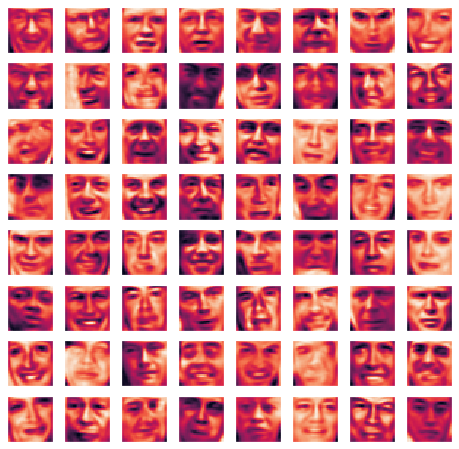

In [104]:
X_rec = recoverData(Z_faces, U_faces)
plotDataPoints(X_rec, n=64)
plt.show()